In [2]:
import numpy as np
from numpy import random
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
import math, decimal
from math import exp
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier,XGBRFClassifier
from collections import Counter
seedRF = 50

In [12]:
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
x = train.drop('LABELS', axis=1)
xMean = x.mean()
x = x.fillna(xMean)
test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)
test_nolabels = test_nolabels.fillna(xMean)

In [9]:
# Splitting trainig/Validation
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)


In [ ]:
## Data shape exploration
print("",np.shape(x_train),"  :",np.shape(x_validation) )
print("Label balance on Training set: ", "\n", y_train['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())

In [12]:
# feature extraction based on domain knowledge (In progress)
ndvi_list = {'NDVI_jan','NDVI_feb','NDVI_mar','NDVI_apr','NDVI_may','NDVI_jun','NDVI_jul','NDVI_aug','NDVI_sep','NDVI_oct','NDVI_nov','NDVI_dec'}
## Extrae los NDVI y escatter contra las labels

In [15]:
### Some helpers function
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        return de predicted classes from the hypotesis function result (sigmoid(W,X))
        @hypotesis : matrix of probablilities 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

def predictOnSet(model, x_test):
    prediction = model.predict(x_test)
    return prediction

def savingModels(classifier, modelFileName):
    '''
    NOTE: Do not forget the extention = *.pkl
    Save as : 'modelFileName.pkl'
    '''
    joblib.dump(classifier, modelFileName)


def importModel(modefname):
    model = joblib.load(modefname)
    return model

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)



In [6]:
## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
    clasifierNameExtended = clasifierName + "_info_fi"     
    fi_model.to_csv(clasifierNameExtended, index = None)
    return fi_model

In [8]:
## XGBOOST
def xgboost(x_train, y_train, x_validation, y_validation):    
    # fit model no training data
    model = XGBClassifier(use_label_encoder=False)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_validation, predictions)
    print("Accuracy xgboost: %.2f%%" % (accuracy * 100.0))
    predictionsDF = formating_prediction(predictions)
    return model, accuracy, predictionsDF

In [9]:
# Random Forest 
def randomForest(x_train, y_train, x_validation, y_validation, estimators):
    '''
    Performe random forest, in the simples way, from Skl library
    @estimators: NUmber of estimators
    return: model "classifier_LR" and a prediction over a x_validation
    '''
    y_train = np.array(y_train)
    y_train =  y_train.ravel()#np.reshape(y_train,(-1,1))
    rf_classifier = RandomForestClassifier(n_estimators = estimators, criterion = 'entropy', random_state = 42)
    rf_classifier.fit(x_train, y_train)

    # Predicting on the validation set
    prediction = rf_classifier.predict(x_validation)
    accuracy = accuracy_score(y_validation, prediction)
    prediction = prediction.astype('int32')
    savingModels(rf_classifier, "rf_simple.pkl")
    ### Comment/Uncomment next line to save prediction on ValidationSet as *.csv
    # savePrediction(prediction, "rf_validatoinPredicted.csv")
    predictions_DF = formating_prediction(prediction)
    return rf_classifier, accuracy, predictions_DF 


In [84]:
#### Ramdomized RF  ####
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200,20).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)


In [26]:
print(np.linspace(10, 200,20).astype(int))

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


In [ ]:
# Random searsh  
y_train = np.array(y_train).ravel()
rs.fit(x_train, y_train)
print(rs.best_params_, "\n")

In [ ]:
### Working with best estimator from RandomizedSearch 
best_model = rs.best_estimator_
savingModels(best_model, "rf_RandomSearch.pkl")

test_nolabels_prediction = predictOnSet(best_model, test_nolabels)
savePrediction(test_nolabels_prediction, 'first_rfSearch_noLabelPrediction.csv')

fi_model = evaluate_model(x_train, y_train, x_validation, y_validation, test_nolabels_prediction)

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}', '\n')
print(f'Average maximum depth {int(np.mean(max_depths))}')



In [ ]:

# recording = dict()
# classifier = joblib.load("rf_RandomSearch.pkl")
for i in range(5): 
    x_train, x_validation, y_train, y_validation = train_test_split(x,y, test_size=0.2)
    y_train = np.array(y_train).ravel()
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    recording[str(i)] = accuracy
    print(str(i) + "_Accuracy: %.2f%%" % (accuracy))
    evaluate_model(x_train, y_train, x_validation, y_validation, classifier)
    modelFileName = str(i)+"recurentRandomSplitRF.pkl"
    joblib.dump(classifier, modelFileName)
    test_nolabels_prediction = predictOnSet(classifier, test_nolabels)
    predictionFilename = str(i)+"predictionFilename.csv"
    savePrediction(test_nolabels_prediction, predictionFilename)

In [ ]:
rf_model = importModel('rf_RandomSearch.pkl')
y_pred = rf_model.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("Accuracy xgboost: %.2f%%" % (accuracy * 100.0))

In [ ]:
resultXGB_CV = []
model = XGBClassifier(use_label_encoder=False, eval_metric= 'logloss')
for i in range(20):
    x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)


In [36]:
estimator = XGBRFClassifier(use_label_encoder=False,subsample=0.9, colsample_bynode=0.2)
param_grid = {
    'n_estimators': np.linspace(50, 400, 4).astype(int),
    'max_depth': [None] + list(np.linspace(3,20,4).astype(int)),
    'max_features': [None] + list(np.arange(0.5, 1, 0.1)),
    'bootstrap': [True]
}
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 4, verbose = 1, random_state=seedRF)

In [ ]:
rs.fit(x_train, y_train)

In [ ]:

best_model = rs.best_estimator_
y_pred = best_model.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("Accuracy xgboost: %.2f%%" % (accuracy))

In [22]:
# best_model = rs.best_estimator_
savingModels(classifier, "RF_multipleRandomSplit.pkl")

test_nolabels_prediction = predictOnSet(classifier, test_nolabels)
savePrediction(test_nolabels_prediction, 'RF_multipleRandomSplit.csv')

# fi_model = evaluate_model(x_train, y_train, x_validation, y_validation, classifier)
# testNoLabelFIrst = pd.read_csv("first_rfSearch_noLabelPrediction.csv", index_col = None)
# accuracy = accuracy_score(testNoLabelFIrst[['LABELS']], test_nolabels_prediction[['LABELS']])
# print("Accuracy xgboost: %.2f%%" % (accuracy))

/usr/local/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- S.No
Feature names seen at fit time, yet now missing:
- Unnamed: 0

  warnings.warn(message, FutureWarning)


In [ ]:
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
y = "Accuracy xgboost: %.2f%%" % (accuracy)
print(y)

Accuracy xgboost: 0.79%


In [ ]:
i =0
clasifierName = "xgboost_singleTest_" + str(0) + "_.pkl"
print(clasifierName)
savingModels(model, clasifierName)

,feature,importance
214,topo_elevation_dec,0.047547
178,topo_elevation_oct,0.045460
34,topo_elevation_feb,0.040106
88,topo_elevation_may,0.035605
196,topo_elevation_nov,0.035303
...,...,...
27,S2_B9_feb,0.000358
61,S2_B8_apr,0.000335
62,S2_B8A_apr,0.000334
0,Unnamed: 0,0.000106


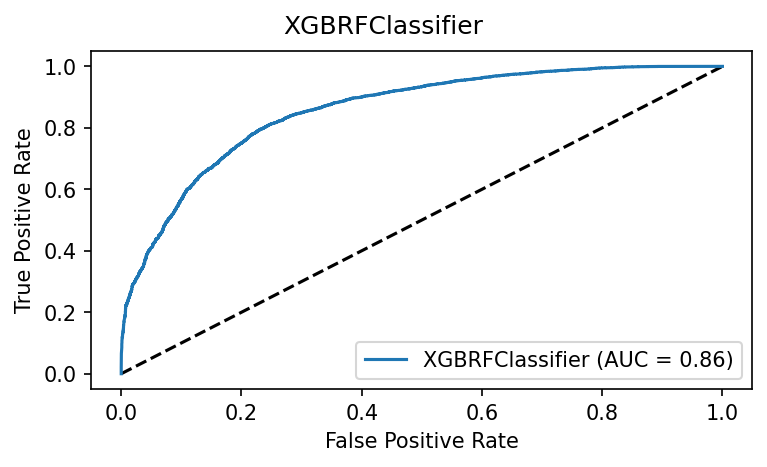

In [ ]:
evaluate_model(x_train, y_train, x_validation, y_validation, model)

In [ ]:
test_nolabels_prediction = model.predict(test_nolabels)

print(test_nolabels_prediction)
test_nolabels_prediction= formating_prediction(test_nolabels_prediction)
# test_nolabels_prediction.to_csv("testing.csv")

[0 1 1 ... 0 0 0]


In [17]:
testNoLabelFIrst = pd.read_csv("first_rfSearch_noLabelPrediction.csv", index_col = None)
accuracy = accuracy_score(testNoLabelFIrst[['LABELS']], test_nolabels_prediction[['LABELS']])
print("Accuracy xgboost: %.2f%%" % (accuracy))


/var/folders/zg/9gnpzxf5429_p5r9cqlb3_1c0000gn/T/ipykernel_16559/277716320.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  accuracy = accuracy_score(testNoLabelFIrst[['LABELS']], test_nolabels_prediction[['LABELS']])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices